**Lab 1**

In [2]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('imdb_master.csv',encoding='latin-1')
print(df.head())

   Unnamed: 0  type  ... label         file
0           0  test  ...   neg      0_2.txt
1           1  test  ...   neg  10000_4.txt
2           2  test  ...   neg  10001_1.txt
3           3  test  ...   neg  10002_3.txt
4           4  test  ...   neg  10003_3.txt

[5 rows x 5 columns]


**Mistake 1 useless data**  
Looking at the target we see that there is a value unsup that mostly likely has  
 no determinate value and makes up half the dataset which could heavily skew the   
   rest so we remove it

In [4]:
labels = df['label'].value_counts()
print(labels)
df = df[df.label != 'unsup']

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64


In [5]:
sentences = df['review'].values
y = df['label'].values

In [6]:
#tokenizing data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(sentences)
#getting the vocabulary of data
sentences = tokenizer.texts_to_matrix(sentences)

In [7]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

[0 0 0 ... 1 1 1]


**Mistake 2 input dimension**  
The input dimension was undeclared so we examine the data to set it for the  
network

In [33]:
print(X_train)
print(X_train.shape)
input_dim = 2000


[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
(37500, 2000)


**Mistake 3 output layer activation**  
Sigmoid is the improper activation so we replace with softmax and change last layer output dimension to 2

**Mistake 1 adjustment**  
Since we removed one of the labels we are only evaluating 2 value so we change  
 the size of the output layer from 3 to 2


In [34]:
# Number of features
print(input_dim)
model = Sequential()
model.add(layers.Dense(300,input_dim=input_dim, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
history=model.fit(X_train,y_train, epochs=5, verbose=True, validation_data=(X_test,y_test), batch_size=256)


2000
Epoch 1/5
147/147 [==============================] - 1s 5ms/step - loss: 0.4325 - acc: 0.7944 - val_loss: 0.3019 - val_acc: 0.8770
Epoch 2/5
147/147 [==============================] - 1s 4ms/step - loss: 0.2479 - acc: 0.8997 - val_loss: 0.2896 - val_acc: 0.8788
Epoch 3/5
147/147 [==============================] - 1s 4ms/step - loss: 0.2003 - acc: 0.9230 - val_loss: 0.2951 - val_acc: 0.8778
Epoch 4/5
147/147 [==============================] - 1s 4ms/step - loss: 0.1377 - acc: 0.9549 - val_loss: 0.3057 - val_acc: 0.8758
Epoch 5/5
147/147 [==============================] - 1s 4ms/step - loss: 0.0738 - acc: 0.9842 - val_loss: 0.3380 - val_acc: 0.8768


391/391 [==============================] - 1s 2ms/step - loss: 0.3380 - acc: 0.8768
Evaluation result on Test Data : Loss = 0.33798539638519287, accuracy = 0.876800000667572 



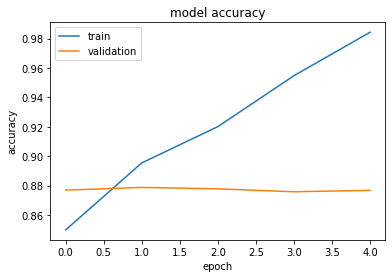

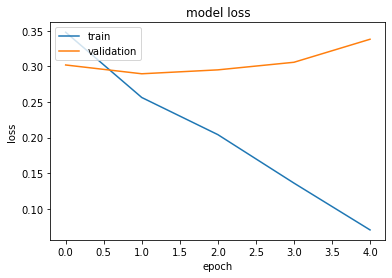

In [38]:
import matplotlib.pyplot as plt

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc), '\n')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Lab 2**  

Using this source as well as the powerpoint example  

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [8]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import tensorflow as tf

# Standard script to load GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUS Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUS Available:  1
Found GPU at: /device:GPU:0


In [9]:
# Reset sentences
sentences = df['review'].values

# Prepping data for embedding layer
max_review_len = max(len(s.split()) for s in sentences)
vocab_size = len(tokenizer.word_index)+1
sentences = tokenizer.texts_to_sequences(sentences)
padded_docs = pad_sequences(sentences, maxlen=max_review_len)
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size=0.25, random_state=1000)

In [10]:
with tf.device('/gpu:0'):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=max_review_len))
  model.add(Flatten())
  model.add(layers.Dense(300, activation='relu'))
  # Switch back to sigmoid for a binary model
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  history=model.fit(X_train,y_train, epochs=5, verbose=True, validation_data=(X_test,y_test), batch_size=256)

Epoch 1/5
147/147 [==============================] - 23s 136ms/step - loss: 1.2038 - acc: 0.5694 - val_loss: 0.3341 - val_acc: 0.8604
Epoch 2/5
147/147 [==============================] - 19s 132ms/step - loss: 0.2976 - acc: 0.8768 - val_loss: 0.2993 - val_acc: 0.8738
Epoch 3/5
147/147 [==============================] - 19s 132ms/step - loss: 0.2450 - acc: 0.9014 - val_loss: 0.2789 - val_acc: 0.8842
Epoch 4/5
147/147 [==============================] - 19s 132ms/step - loss: 0.2017 - acc: 0.9227 - val_loss: 0.2834 - val_acc: 0.8824
Epoch 5/5
147/147 [==============================] - 19s 132ms/step - loss: 0.1668 - acc: 0.9405 - val_loss: 0.2928 - val_acc: 0.8808


391/391 [==============================] - 2s 6ms/step - loss: 0.2928 - acc: 0.8808
Evaluation result on Test Data : Loss = 0.2928091883659363, accuracy = 0.8808000087738037 



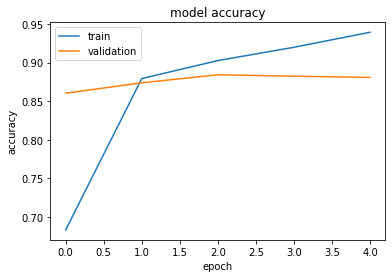

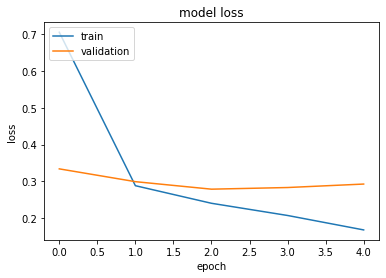

In [11]:
import matplotlib.pyplot as plt

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc), '\n')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()